In [ ]:
"""
A simple test to check if the RFAE model loads and runs properly
on toy datasets, producing train/test embeddings.
"""

from rfae import RFAE
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# Loading functions

In [2]:
def load_dataset(data_name="optdigits", subsample_size=None, random_state=42):

    # Load full dataset
    if data_name == "mnist":
        mnist = fetch_openml(data_id=554, as_frame=False)
        x = mnist.data.astype(float)
        y = mnist.target.astype(int)

    elif data_name == "fmnist":
        fmnist = fetch_openml(data_id=40996, as_frame=False)
        x = fmnist.data.astype(float)
        y = fmnist.target.astype(int)

    elif data_name == "usps":
        usps = fetch_openml(data_id=41082, as_frame=False)
        x = usps.data.astype(float)
        y = usps.target.astype(int)

    elif data_name == "optdigits":
        digits = load_digits()
        x = digits.data.astype(float)
        y = digits.target.astype(int)

    elif data_name == "coil20":
        coil = fetch_openml(data_id=40979, as_frame=False)
        x = coil.data.astype(float)
        y = coil.target.astype(int)

    else:
        raise ValueError(f"Unknown dataset: {data_name}")

    print(f"Loaded {data_name}: X={x.shape}, y={y.shape}")

    # Optional stratified subsample BEFORE train/test split
    if subsample_size is not None and subsample_size < len(y):
        sss = StratifiedShuffleSplit(
            n_splits=1,
            train_size=subsample_size,
            random_state=random_state
        )
        idx_sub, _ = next(sss.split(x, y))
        x = x[idx_sub]
        y = y[idx_sub]
        print(f"Stratified subsample: {x.shape[0]} samples retained.")

    return x, y

# Load data

In [3]:
data_name = "fmnist"
x, y = load_dataset(data_name, subsample_size=30000)

print(f"Final dataset: Samples={len(x)}, Features={x.shape[1]}")

Loaded fmnist: X=(70000, 784), y=(70000,)
Stratified subsample: 30000 samples retained.
Final dataset: Samples=30000, Features=784



# Split into train/test sets


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and fit RFAE


In [ ]:
model = RFAE(
    n_components=2,
    epochs=200,
    lam=0.01,
    recon_loss_type='kl',
    n_prototypes=500,
    random_state=42
    )


emb_train = model.fit_transform(x_train, y_train)
emb_test = model.transform(x_test)

print("Embedding shapes:", emb_train.shape, emb_test.shape)

2025-11-19 00:40:31,436 - INFO - Using device: mps
    SGD-MDS may not have converged: stress changed by -1.6% in final iterations. Consider increasing n_iter or adjusting learning_rate.
2025-11-19 00:44:01,682 - INFO - Selected 500 prototypes out of 24000 samples (2.08%).
2025-11-19 00:44:02,784 - INFO - Epoch 0/200 - Recon Loss: 3.1795962 - Geo Loss: 0.0005519
2025-11-19 00:44:05,448 - INFO - Epoch 10/200 - Recon Loss: 0.9400533 - Geo Loss: 0.0003608
2025-11-19 00:44:08,078 - INFO - Epoch 20/200 - Recon Loss: 0.8845838 - Geo Loss: 0.0001705
2025-11-19 00:44:10,563 - INFO - Epoch 30/200 - Recon Loss: 0.8470258 - Geo Loss: 0.0001207
2025-11-19 00:44:13,141 - INFO - Epoch 40/200 - Recon Loss: 0.8226589 - Geo Loss: 0.0001154
2025-11-19 00:44:15,732 - INFO - Epoch 50/200 - Recon Loss: 0.8050044 - Geo Loss: 0.0001132
2025-11-19 00:44:18,390 - INFO - Epoch 60/200 - Recon Loss: 0.7853988 - Geo Loss: 0.0001079
2025-11-19 00:44:20,913 - INFO - Epoch 70/200 - Recon Loss: 0.7717645 - Geo Loss: 0

# Visualization

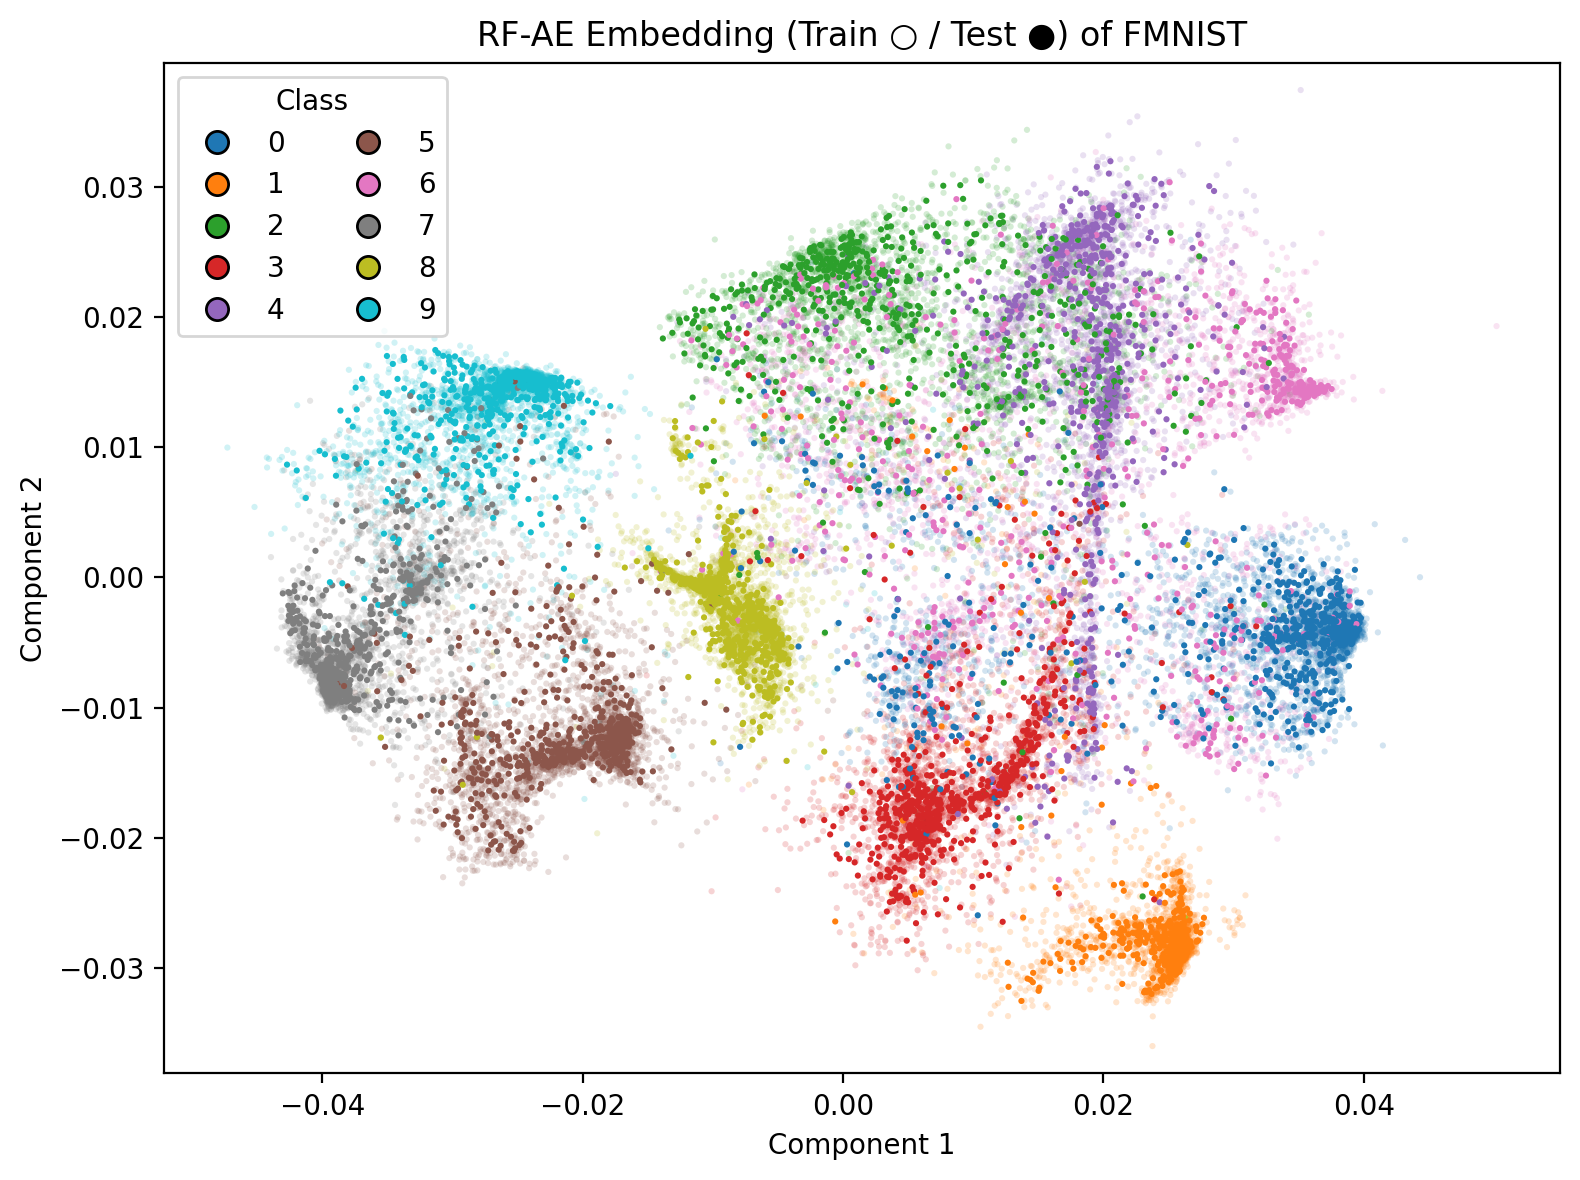

In [6]:
plt.figure(figsize=(8, 6), dpi=200)

# Plot training (circles) and test (triangles)
train_scatter = plt.scatter(
    emb_train[:, 0], emb_train[:, 1],
    c=y_train, cmap='tab10',
    s=5, alpha=0.2, marker='o', linewidths=0
)
test_scatter = plt.scatter(
    emb_test[:, 0], emb_test[:, 1],
    c=y_test, cmap='tab10',
    s=5, alpha=1, marker='o', linewidths=0
)

plt.title("RF-AE Embedding (Train ○ / Test ●) of " + data_name.upper())
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

# Create dot-based legend: one dot per class (color-coded)
classes = np.unique(np.concatenate([y_train, y_test]))
cmap = plt.get_cmap('tab10')
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='none',
        markerfacecolor=cmap(i % 10),
        markersize=8,
        label=str(cls)
    )
    for i, cls in enumerate(classes)
]

plt.legend(
    handles=handles,
    title="Class",
    loc='best',
    frameon=True,
    ncol=2
)

plt.tight_layout()
plt.show()